# Text Classification For Serbian Science Journals
<p>
The goal of this project is to see how different text classification algorithms classify text paragraphs of articles from Serbian scientific journals.


The data used for this project was made using an online archive of published Serbian scientific journals called 'Srpski Citatni Indeks', link of the site:
https://scindeks.ceon.rs/  
Data contains 1700 paragraphs that are split into 9 categories. These are the following categories: 
   - Architecture and construction engineering
   - Biology
   - Economy
   - Geoscience
   - Chemistry
   - Informatics and electrical engineering
   - Mathematics
   - Medicine
   - Agriculture

   
Each paragraph is also labeled whether it is written in Serbian or English. Due to the nature of Serbian scientific community, there are more scientific works in English language as they are more available to the international community. Some categories have only scientific works that are written in English, as there are minimal to none written in Serbian. Here is the ratio of Serbian to English paragraphs 
for each category:
   - Architecture and construction engineering - Serbian ~48%, English ~52%
   - Biology - Serbian ~39%, English 71%
   - Economy - Serbian ~45%, English ~55%
   - Geoscience - Serbian ~30%, English ~%70
   - Chemistry - Serbian 0%, English 100%
   - Informatics and electrical engineering - Serbian ~3%, English ~97%
   - Mathematics - Serbian 0%, Englsih 100%
   - Medicine - Serbian ~52%, English ~48%
   - Agriculture - Serbian ~51%, English 49%


Algorithms that are used in this project are: Multionomial Naive Bayes, K-Nearest Neighbours and Support Vector Machine. Besides them there are two vectorizers on which the algorithms are tested on: CountVectorizer and TfidfVectorizer

Libraries that are included in this project are: Skicit-Learn, Pandas, Numpy, MatplotLib, NLTK and a Serbian library for NLP, SrbAi

Metrics for evaluation are Skicit-Learns Accuracy and Macro Average metrics.

The data is split 70% into test data, 15% into validation data, 15% into test data
</p>




In [1]:
import re
import pandas as pd
import numpy as np
from srbai.SintaktickiOperatori import spellcheck
from srbai.SintaktickiOperatori.stemmer_nm import stem_str, stem_arr
from srbai.JezickiModeli import FastText
from sklearn.naive_bayes import MultinomialNB
import csv
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<p>We load the csv file content, define its delimiter, and rewrite it into a new csv file, with lineterminators accurately representing end of each row</p>

In [2]:
custom_dialect = csv.excel()
custom_dialect.delimiter = '»'

file_path = 'data/serbian_science_journals_dataset.csv'

with open(file_path, 'r', encoding="utf-8") as file:
    file_content = file.read()

In [3]:

file_content = file_content.replace('\n', '').replace('\r', '').replace('\t', '')
file_content = file_content.replace('«', '\n')

with open('data/serbian_science_journals_dataset_modified.csv', 'w', encoding="utf-8") as file:
    file.write(file_content)

file_path = 'data/serbian_science_journals_dataset_modified.csv'

In [4]:
with open(file_path, 'r', newline='', encoding="utf-8") as csv_file:
    reader = csv.reader(csv_file, dialect=custom_dialect)
    data = list(reader)

df = pd.DataFrame(data)

# Preprocessing

<p>We filter through insufficient characters in our data</p>

In [5]:
pattern = r"[/&|!,:;()\@.#\'\"\[\]{}+\^*/=\$_–—%€°™©><`~0-9-]"
df = df.replace(pattern, ' ', regex=True)
df = df.replace(r"[?]", 'cy', regex=True)

pattern = r"[\r\n\t\u000a\u000b\u000c\u000d\u0085\u2028\u2029\u00a0\u1680\u2000\u2001\u2002\u2003\u2004\u2005\u2006\u2007\u2008\u2009\u200a\u202f\u205f\u3000]"
df = df.replace(pattern, ' ', regex=True)

<p>We define our collections per column, one for languages, one for categories, and one where our paragraphs are stored</p>

In [6]:
column_length = len(df[1])
df_language_collection = [[] for _ in range(column_length)]
df_label_collection = [[] for _ in range(column_length)]
df_token_collection = [[] for _ in range(column_length)]

for idx, language in enumerate(df[2]):
    df_language_collection[idx] = language

for idx, label in enumerate(df[0]):
    df_label_collection[idx] = label

for idx, text_paragraph in enumerate(df[1]):
    text_paragraph = text_paragraph.lower()
    df_token_collection[idx] = nltk.WhitespaceTokenizer().tokenize(text_paragraph)


<p>We iterate through the collection of tokens, each according to their language label, if the token is in Serbian we use SrbAi's Stemming and stop words from their package as well as some custom additional words of ours. If the token is in English we use NLTK's WordNetLemmatizer and also add some custom additional stop words according to our projects needs</p>

In [7]:
#CONTENT OF 'serbian_stopwords.txt' FILE IS COPIED FROM SRBAI serbian_stopwords.txt FILE
file_path = 'stop_words/serbian_stopwords.txt'

with open(file_path, 'r', newline='', encoding='utf-8') as file:
    data = file.read()

serbian_stop_words = data.split(',')
english_stop_words = stopwords.words()

if(serbian_stop_words.__contains__('jesam') or serbian_stop_words.__contains__('ali') or serbian_stop_words.__contains__('ili') or
   serbian_stop_words.__contains__('slika') or serbian_stop_words.__contains__('tabela') or serbian_stop_words.__contains__('tab')):
    serbian_stop_words.append('jesam','ali','ili','slika','tabela','tab')


if(english_stop_words.__contains__('table') or english_stop_words.__contains__('image') or english_stop_words.__contains__('figure') or
   english_stop_words.__contains__('fig')):
    english_stop_words.append('table', 'image', 'figure', 'fig')



In [8]:
lemmatizer = nltk.stem.WordNetLemmatizer()

for idx, text_paragraph in enumerate(df[1]):

    if df_language_collection[idx] == 'Serbian':
        df_token_collection[idx] = stem_arr(text_paragraph)
        df_token_collection[idx] = [token for token in df_token_collection[idx] if len(token) > 2]

        df_token_collection[idx] = [token for token in df_token_collection[idx] if token not in serbian_stop_words]
        df_token_collection[idx] = [token for token in df_token_collection[idx] if token not in english_stop_words]

#        print("Serbian")
#        print(df_token_collection[idx])
    else:
        df_token_collection[idx] = nltk.WhitespaceTokenizer().tokenize(text_paragraph)
        df_token_collection[idx] = [token for token in df_token_collection[idx] if len(token) > 2]
        for idx_token, _ in enumerate(df_token_collection[idx]):
            df_token_collection[idx][idx_token] = lemmatizer.lemmatize(df_token_collection[idx][idx_token])
            df_token_collection[idx][idx_token] = df_token_collection[idx][idx_token].lower()

        df_token_collection[idx] = [token for token in df_token_collection[idx] if token not in english_stop_words]

#        print("English")
#        print(df_token_collection[idx])


# Vectorizers

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score


In [10]:
countVectorizer = CountVectorizer()
tfidfVectorizer = TfidfVectorizer()
classifier = MultinomialNB()
label_encoder = LabelEncoder()

<p>We conjoin our tokens into a document string</p>

In [11]:
df_x = [[] for _ in range(column_length)]
for idx, _ in enumerate(df_x):
    df_x[idx] = " ".join(df_token_collection[idx])

df_x_documents = [' '.join(tokens) for tokens in df_token_collection]

<p>Our random seed</p>

In [12]:
random_state_seed = 42

<p>We fit and transform our data to the vectors, and encode our categories in y</p>

In [13]:
X = [[] for _ in range(column_length)]
y = [[] for _ in range(column_length)]

X = countVectorizer.fit_transform(df_x_documents)
y = label_encoder.fit_transform(df_label_collection)

X_tf = tfidfVectorizer.fit_transform(df_x_documents)

<p>Size of our vocabulary</p>

In [14]:
print("Vocabulary size:")
print(len(countVectorizer.vocabulary_))

Vocabulary size:
58527


# Validation Data

<p>We split our data into train and validation data, according to the random seed</p>

In [15]:
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.15, random_state=random_state_seed)

X_train_tf, x_validate_tf, y_train_tf, y_validate_tf = train_test_split(X_tf, y, test_size=0.15, random_state=random_state_seed)

<p>We fit and predict our data according to our classifier, then we represent how accurate the predictions are with Accuracy and Macro Average metric scores, and with confusion matrix visually as well. We test our algorithm on both CountVectorizer, as well as TfidfVectorizer</p>

<p>Multinomial Naive Bayes with Count Vectorizer </p>

Accuracy score: 
0.8431372549019608
Macro Average score: 
0.8449830332471222


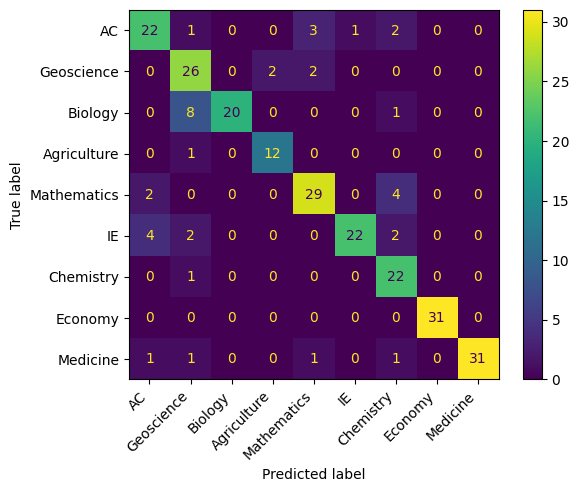

In [16]:
multinomialnb_classifier = MultinomialNB()

multinomialnb_classifier.fit(X_train, y_train)

y_pred = multinomialnb_classifier.predict(X_validate)



accuracy = accuracy_score(y_validate, y_pred)
print("Accuracy score: " )
print(accuracy)
macro_average = f1_score(y_validate, y_pred, average='macro')
print("Macro Average score: ")
print(macro_average)

display_labels = [ 'AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 
                                                                             'IE','Chemistry','Economy','Medicine']
cm = confusion_matrix(y_validate,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=display_labels) 
cm_display.plot()
plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
plt.show()

<p>Multinomial Naive Bayes with TF-IDF Vectorizer </p>

Accuracy score: 
0.807843137254902
Macro Average score: 
0.8041011856720091


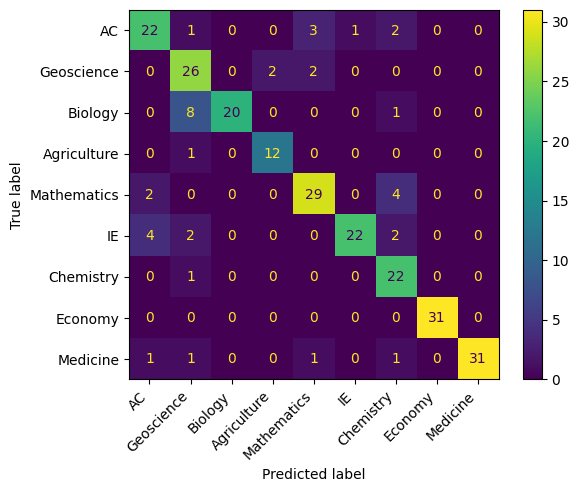

In [17]:
multinomialnb_classifier.fit(X_train_tf, y_train_tf)

y_pred_tf = multinomialnb_classifier.predict(x_validate_tf)



accuracy = accuracy_score(y_validate_tf, y_pred_tf)
print("Accuracy score: " )
print(accuracy)
macro_average = f1_score(y_validate_tf, y_pred_tf, average='macro')
print("Macro Average score: ")
print(macro_average)

display_labels = [ 'AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 
                                                                             'IE','Chemistry','Economy','Medicine']
cm = confusion_matrix(y_validate,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=display_labels) 
cm_display.plot()
plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
plt.show()

In [18]:
from sklearn.neighbors import KNeighborsClassifier


<p>K-Nearest Neighbors with Count Vectorizer </p>

Accuracy score: 
0.24705882352941178
Macro Average score: 
0.22908773976849092


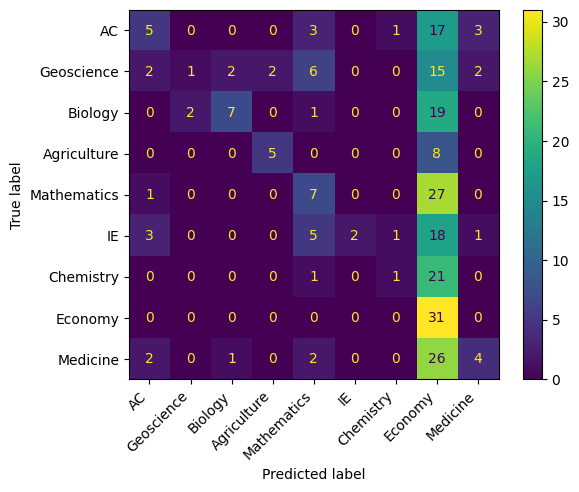

In [19]:
knn_classifier = KNeighborsClassifier(n_neighbors=9)
knn_classifier.fit(X_train, y_train)

y_pred = knn_classifier.predict(X_validate)



accuracy = accuracy_score(y_validate, y_pred)
print("Accuracy score: " )
print(accuracy)
macro_average = f1_score(y_validate, y_pred, average='macro')
print("Macro Average score: ")
print(macro_average)

display_labels = ['AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 
                                                                             'IE','Chemistry','Economy','Medicine']
cm = confusion_matrix(y_validate,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=display_labels) 
cm_display.plot()
plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
plt.show()

<p>K-Nearest Neighbors with TF-IDF Vectorizer </p>

Accuracy score: 
0.8
Macro Average score: 
0.7964658798408162


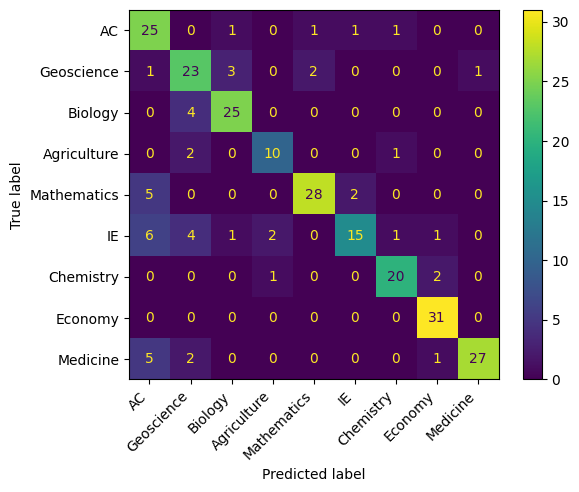

In [20]:
knn_classifier.fit(X_train_tf, y_train_tf)

y_pred_tf = knn_classifier.predict(x_validate_tf)



accuracy = accuracy_score(y_validate_tf, y_pred_tf)
print("Accuracy score: " )
print(accuracy)
macro_average = f1_score(y_validate_tf, y_pred_tf, average='macro')
print("Macro Average score: ")
print(macro_average)

display_labels = ['AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 
                                                                             'IE','Chemistry','Economy','Medicine']
cm = confusion_matrix(y_validate_tf,y_pred_tf)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=display_labels) 
cm_display.plot()
plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
plt.show()



In [21]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

<p>Support Vector Machine with Counter Vectorizer </p>

Accuracy score: 
0.7372549019607844
Macro Average score: 
0.7393024026491746


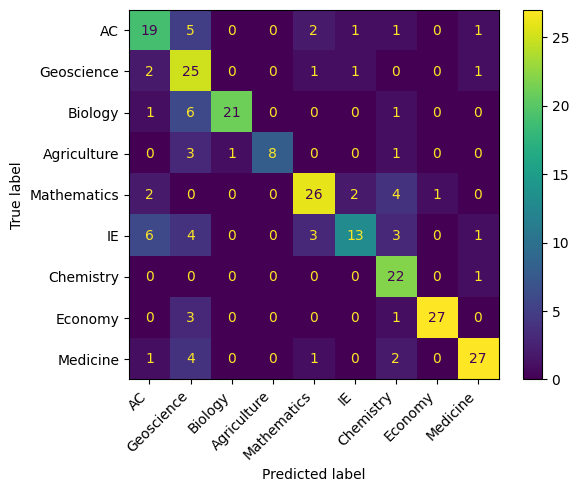

In [22]:
svc_classifier = SVC()
svc_classifier.fit(X_train, y_train)

y_pred = svc_classifier.predict(X_validate)



accuracy = accuracy_score(y_validate, y_pred)
print("Accuracy score: " )
print(accuracy)
macro_average = f1_score(y_validate, y_pred, average='macro')
print("Macro Average score: ")
print(macro_average)

display_labels = ['AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 
                                                                             'IE','Chemistry','Economy','Medicine']
cm = confusion_matrix(y_validate,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=display_labels) 
cm_display.plot()
plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
plt.show()

<p>Support Vector Machine with TF-IDF Vectorizer </p>

Accuracy score: 
0.8392156862745098
Macro Average score: 
0.8314847865207708


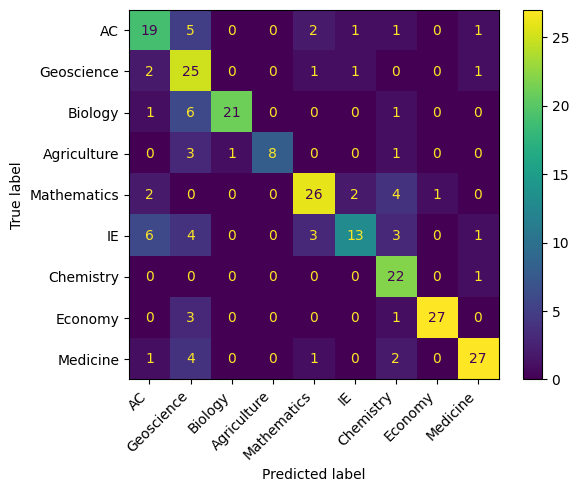

In [23]:
svc_classifier.fit(X_train_tf, y_train_tf)

y_pred_tf = svc_classifier.predict(x_validate_tf)



accuracy = accuracy_score(y_validate_tf, y_pred_tf)
print("Accuracy score: " )
print(accuracy)
macro_average = f1_score(y_validate_tf, y_pred_tf, average='macro')
print("Macro Average score: ")
print(macro_average)

display_labels = ['AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 
                                                                             'IE','Chemistry','Economy','Medicine']
cm = confusion_matrix(y_validate,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=display_labels) 
cm_display.plot()
plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
plt.show()

# Test Data

<p>Now we test our data on fine-tuned variations of our algorithms</p>

In [24]:
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import GridSearchCV




<p>We split our data into train and test data, according to the random seed</p>

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=random_state_seed)

X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_tf, y, test_size=0.15, random_state=random_state_seed)

<p>Multinomial Naive Bayes Count Vectorizer </p>

Accuracy score: 
0.8431372549019608
Macro Average score: 
0.8449830332471222


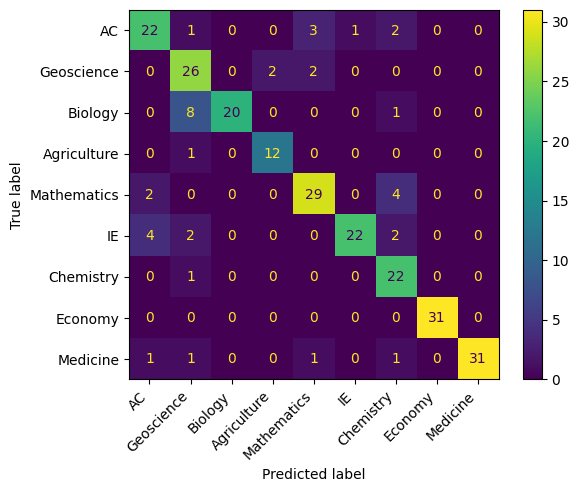

In [26]:

multinomialnb_classifier = MultinomialNB(alpha=1)
multinomialnb_classifier.fit(X_train, y_train)


y_pred = multinomialnb_classifier.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score: " )
print(accuracy)
macro_average = f1_score(y_test, y_pred, average='macro')
print("Macro Average score: ")
print(macro_average)

display_labels = ['AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 
                                                                              'IE','Chemistry','Economy','Medicine']
cm = confusion_matrix(y_test,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=display_labels) 
cm_display.plot()
plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
plt.show()

<p>Multinomial Naive Bayes TF-IDF Vectorizer </p>

Accuracy score: 
0.807843137254902
Macro Average score: 
0.8041011856720091


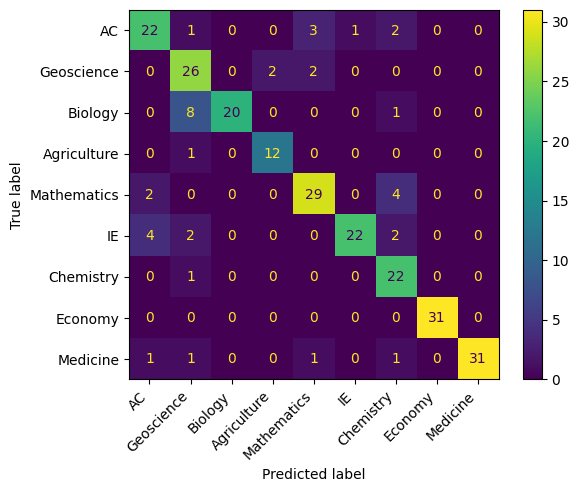

In [27]:
multinomialnb_classifier.fit(X_train_tf, y_train_tf)

y_pred_tf = multinomialnb_classifier.predict(x_validate_tf)



accuracy = accuracy_score(y_test_tf, y_pred_tf)
print("Accuracy score: " )
print(accuracy)
macro_average = f1_score(y_test_tf, y_pred_tf, average='macro')
print("Macro Average score: ")
print(macro_average)

display_labels = [ 'AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 
                                                                             'IE','Chemistry','Economy','Medicine']
cm = confusion_matrix(y_test_tf,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=display_labels) 
cm_display.plot()
plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
plt.show()

<p>Imporved K-Nearest Neighbor with Count Vectorizer </p>

Accuracy score: 
0.396078431372549
Macro Average score: 
0.39443126448776167


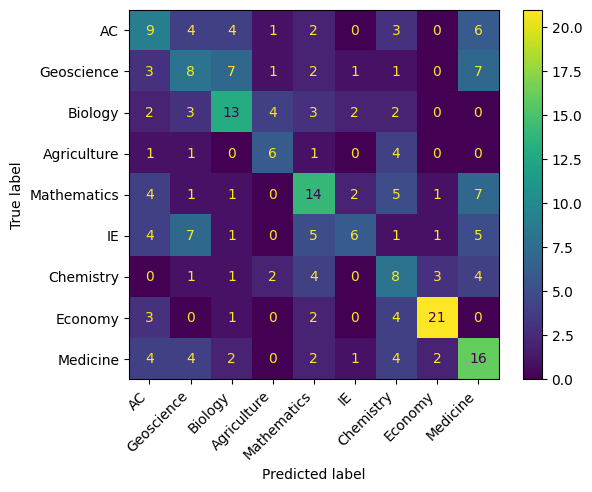

In [28]:
from sklearn.neighbors import KNeighborsTransformer

knn_transformer = KNeighborsTransformer(n_neighbors=9)
knn_classifier = KNeighborsClassifier(weights='distance')

knn_pipeline = make_pipeline(knn_transformer, knn_classifier)
knn_pipeline.fit(X_train, y_train)

y_pred = knn_pipeline.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score: " )
print(accuracy)
macro_average = f1_score(y_test, y_pred, average='macro')
print("Macro Average score: ")
print(macro_average)

display_labels = ['AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 
                                                                             'IE','Chemistry','Economy','Medicine']
cm = confusion_matrix(y_test,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=display_labels) 
cm_display.plot()
plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
plt.show()

<p>Improved K-Nearest Neighbor with TF-IDF Vectorizer </p>

Accuracy score: 
0.792156862745098
Macro Average score: 
0.7975575502214848


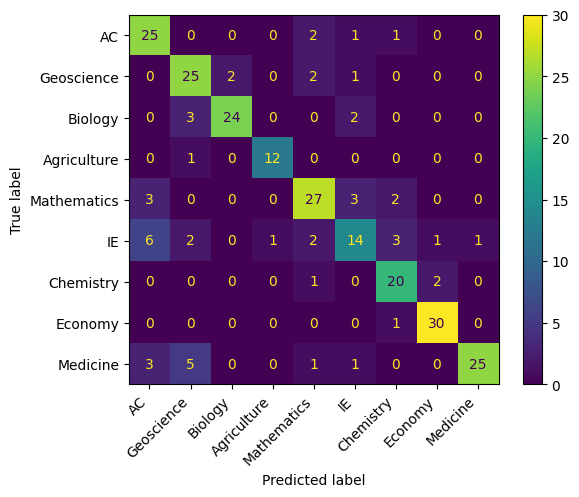

In [29]:
knn_classifier.fit(X_train_tf, y_train_tf)

y_pred_tf = knn_classifier.predict(x_validate_tf)


accuracy = accuracy_score(y_test_tf, y_pred_tf)
print("Accuracy score: " )
print(accuracy)
macro_average = f1_score(y_test_tf, y_pred_tf, average='macro')
print("Macro Average score: ")
print(macro_average)

display_labels = ['AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 
                                                                             'IE','Chemistry','Economy','Medicine']
cm = confusion_matrix(y_test_tf,y_pred_tf)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=display_labels) 
cm_display.plot()
plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
plt.show()

<p>Improved Support Vector Machine with Count Vectorizer </p>

Accuracy score: 
0.807843137254902
Macro Average score: 
0.8101442255712243


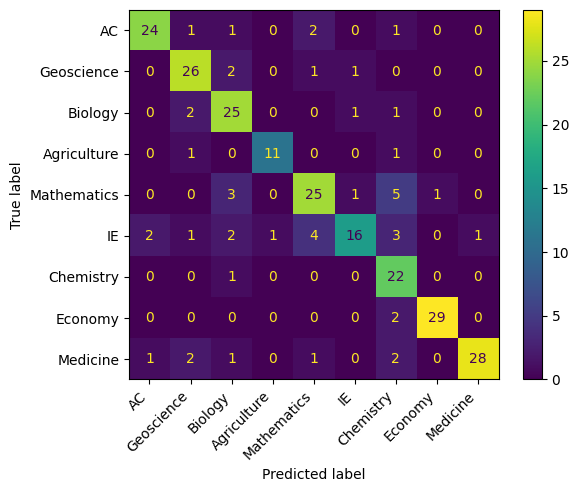

In [30]:

svc_classifier = SVC(kernel='sigmoid')


svc_classifier.fit(X_train, y_train)

y_pred = svc_classifier.predict(X_validate)



accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score: " )
print(accuracy)
macro_average = f1_score(y_test, y_pred, average='macro')
print("Macro Average score: ")
print(macro_average)

display_labels = ['AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 
                                                                             'IE','Chemistry','Economy','Medicine']
cm = confusion_matrix(y_test,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=display_labels) 
cm_display.plot()
plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
plt.show()

<p>Improved Support Vector Machine with TF-IDF Vectorizer </p>

Accuracy score: 
0.8901960784313725
Macro Average score: 
0.8929060789493598


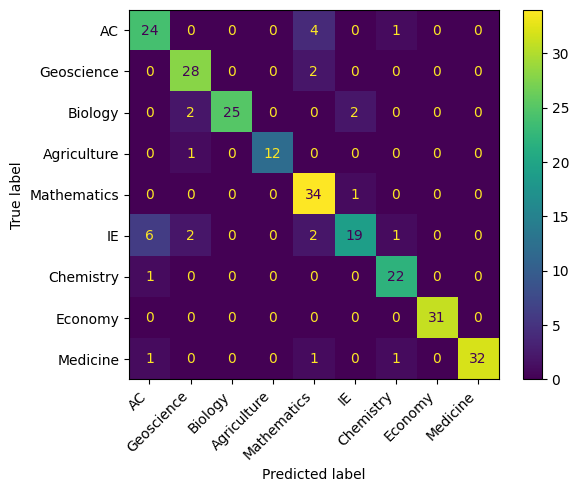

In [31]:
svc_classifier.fit(X_train_tf, y_train_tf)

y_pred_tf = svc_classifier.predict(x_validate_tf)



accuracy = accuracy_score(y_test_tf, y_pred_tf)
print("Accuracy score: " )
print( accuracy)
macro_average = f1_score(y_test_tf, y_pred_tf, average='macro')
print("Macro Average score: ")
print( macro_average)

display_labels = ['AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 
                                                                             'IE','Chemistry','Economy','Medicine']
cm = confusion_matrix(y_test_tf,y_pred_tf)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=display_labels) 
cm_display.plot()
plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
plt.show()

# Addition to the Original Project: MLP Classifier

<p>Addition to the original project is testing the Skicit-Learns Multilayer Perceptron (MLP) Classifier. Here it is tested on both Count and TF-IDF vectorizers, with validation data, as well as with fine-tuned parameters for test data. Besides these two vectorizers, Word2Vec vectorization is also tested on this algorithm</p>

Results show MLPs great performances with Count and TF-IDF Vectorizers, while lower with Word2Vec, however still substantially better performance than if we were to use any other algoritm in our project with Word2Vec vectorization.

<p>Multilayer Perceptron with Count Vectorizer</p>

Iteration 1, loss = 2.00808245
Iteration 2, loss = 0.76041247
Iteration 3, loss = 0.25037023
Iteration 4, loss = 0.09867382
Iteration 5, loss = 0.04989943
Iteration 6, loss = 0.03052727
Iteration 7, loss = 0.02165807
Iteration 8, loss = 0.01644273
Iteration 9, loss = 0.01332532
Iteration 10, loss = 0.01136180
Iteration 11, loss = 0.00989789
Iteration 12, loss = 0.00873087
Iteration 13, loss = 0.00787388
Iteration 14, loss = 0.00715164
Iteration 15, loss = 0.00653085
Iteration 16, loss = 0.00603655
Iteration 17, loss = 0.00561217
Iteration 18, loss = 0.00522291
Iteration 19, loss = 0.00488520
Iteration 20, loss = 0.00458556
Iteration 21, loss = 0.00433982
Iteration 22, loss = 0.00411667
Iteration 23, loss = 0.00392400
Iteration 24, loss = 0.00375870
Iteration 25, loss = 0.00358987
Iteration 26, loss = 0.00345355
Iteration 27, loss = 0.00332423
Iteration 28, loss = 0.00320571
Iteration 29, loss = 0.00309878
Iteration 30, loss = 0.00299555
Iteration 31, loss = 0.00289982
Iteration 32, los

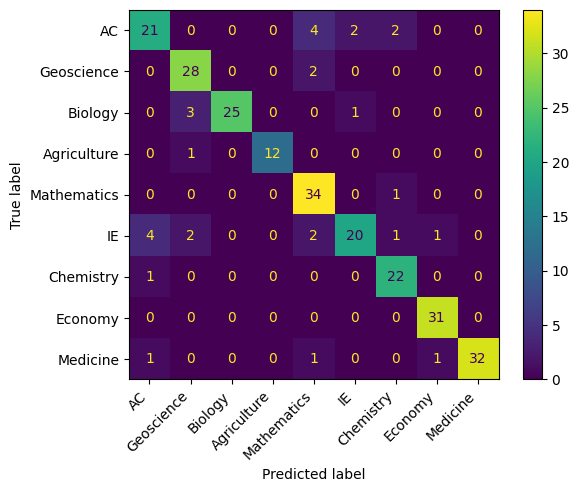

In [32]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), random_state=random_state_seed, verbose=True)
mlp_classifier.fit(X_train, y_train)

y_pred = mlp_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score:", accuracy)

macro_average = f1_score(y_test, y_pred, average='macro')
print("Macro Average score:", macro_average)

display_labels = ['AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 'IE', 'Chemistry', 'Economy', 'Medicine']
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
cm_display.plot()
plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
plt.show()


<p>Improved Multilayer Perceptron with Count Vectorizer, with very minimal improvement</p>

Iteration 1, loss = 1.61425973
Iteration 2, loss = 0.21221671
Iteration 3, loss = 0.04326226
Iteration 4, loss = 0.01915132
Iteration 5, loss = 0.01225991
Iteration 6, loss = 0.00946954
Iteration 7, loss = 0.00785725
Iteration 8, loss = 0.00674994
Iteration 9, loss = 0.00601940
Iteration 10, loss = 0.00541330
Iteration 11, loss = 0.00495258
Iteration 12, loss = 0.00459955
Iteration 13, loss = 0.00430266
Iteration 14, loss = 0.00406223
Iteration 15, loss = 0.00386058
Iteration 16, loss = 0.00367869
Iteration 17, loss = 0.00353229
Iteration 18, loss = 0.00338628
Iteration 19, loss = 0.00327348
Iteration 20, loss = 0.00317007
Iteration 21, loss = 0.00306977
Iteration 22, loss = 0.00298914
Iteration 23, loss = 0.00290186
Iteration 24, loss = 0.00281680
Iteration 25, loss = 0.00274336
Iteration 26, loss = 0.00268558
Iteration 27, loss = 0.00260412
Iteration 28, loss = 0.00254977
Iteration 29, loss = 0.00247558
Iteration 30, loss = 0.00240581
Iteration 31, loss = 0.00234565
Iteration 32, los

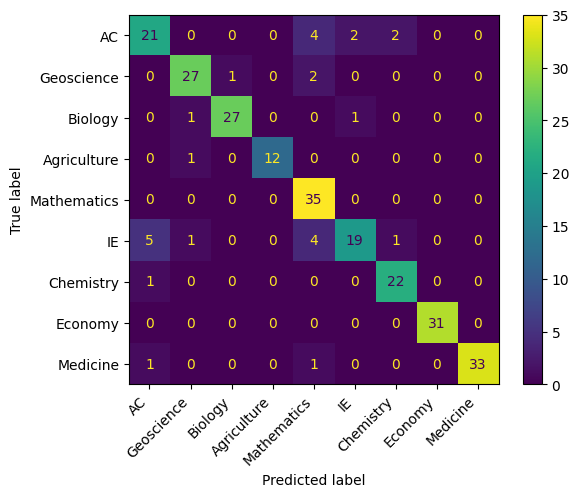

In [33]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(50,), random_state=random_state_seed, alpha=0.0003, batch_size=100, learning_rate='adaptive',verbose=True,
                               n_iter_no_change=10, learning_rate_init=0.002, max_iter=1000)
mlp_classifier.fit(X_train, y_train)

y_pred = mlp_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score:", accuracy)

macro_average = f1_score(y_test, y_pred, average='macro')
print("Macro Average score:", macro_average)

display_labels = ['AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 'IE', 'Chemistry', 'Economy', 'Medicine']
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
cm_display.plot()
plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
plt.show()


<p>Multilayer Perceptron with TF-IDF Vectorizer</p>

Iteration 1, loss = 2.27695311
Iteration 2, loss = 2.14349898
Iteration 3, loss = 1.96402575
Iteration 4, loss = 1.74868006
Iteration 5, loss = 1.51244175
Iteration 6, loss = 1.26850906
Iteration 7, loss = 1.03031985
Iteration 8, loss = 0.81186275
Iteration 9, loss = 0.62481410
Iteration 10, loss = 0.47528342
Iteration 11, loss = 0.36086268
Iteration 12, loss = 0.27635247
Iteration 13, loss = 0.21579984
Iteration 14, loss = 0.17164495
Iteration 15, loss = 0.13963970
Iteration 16, loss = 0.11595420
Iteration 17, loss = 0.09795590
Iteration 18, loss = 0.08405195
Iteration 19, loss = 0.07313291
Iteration 20, loss = 0.06438585
Iteration 21, loss = 0.05736603
Iteration 22, loss = 0.05159417
Iteration 23, loss = 0.04671760
Iteration 24, loss = 0.04260887
Iteration 25, loss = 0.03906924
Iteration 26, loss = 0.03600110
Iteration 27, loss = 0.03335377
Iteration 28, loss = 0.03104932
Iteration 29, loss = 0.02902214
Iteration 30, loss = 0.02721292
Iteration 31, loss = 0.02559926
Iteration 32, los

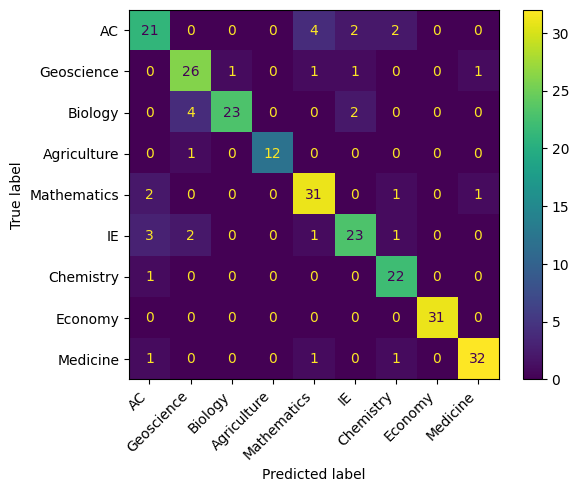

In [34]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), random_state=random_state_seed, verbose=True)
mlp_classifier.fit(X_train_tf, y_train_tf)

y_pred_tf = mlp_classifier.predict(X_test_tf)

accuracy = accuracy_score(y_test_tf, y_pred_tf)
print("Accuracy score:", accuracy)

macro_average = f1_score(y_test_tf, y_pred_tf, average='macro')
print("Macro Average score:", macro_average)

display_labels = ['AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 'IE', 'Chemistry', 'Economy', 'Medicine']
cm = confusion_matrix(y_test_tf, y_pred_tf)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
cm_display.plot()
plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
plt.show()


<p>Improved Multilayer Perceptron with TF-IDF Vectorizer</p>

Iteration 1, loss = 2.07184447
Iteration 2, loss = 0.63250560
Iteration 3, loss = 0.05320696
Iteration 4, loss = 0.01676463
Iteration 5, loss = 0.01772770
Iteration 6, loss = 0.01930356
Iteration 7, loss = 0.02003110
Iteration 8, loss = 0.02005273
Iteration 9, loss = 0.01981193
Iteration 10, loss = 0.01947486
Training loss did not improve more than tol=0.000100 for 5 consecutive epochs. Stopping.
Accuracy score: 0.8941176470588236
Macro Average score: 0.8940942382796196


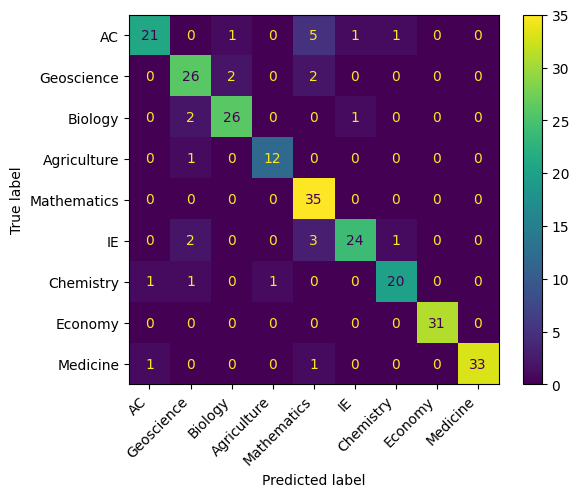

In [35]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(750,), random_state=random_state_seed, alpha=0.0003, batch_size=300, learning_rate='adaptive',verbose=True,
                               n_iter_no_change=5, learning_rate_init=0.005, max_iter=1000)
mlp_classifier.fit(X_train_tf, y_train_tf)

y_pred_tf = mlp_classifier.predict(X_test_tf)

accuracy = accuracy_score(y_test_tf, y_pred_tf)
print("Accuracy score:", accuracy)

macro_average = f1_score(y_test_tf, y_pred_tf, average='macro')
print("Macro Average score:", macro_average)

display_labels = ['AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 'IE', 'Chemistry', 'Economy', 'Medicine']
cm = confusion_matrix(y_test_tf, y_pred_tf)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
cm_display.plot()
plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
plt.show()


<p>Creating new data for Word2Vec vectorizer, here we take per each paragraph a mean vector value of the words vector value in that paragraph for fitting. Due to the size of our data set we have to reduce its dimensionality, as well as to perform normalization of our vector values to non-negative.</p>

In [36]:
from gensim.models import Word2Vec
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

X_train, X_validate, y_train, y_validate = train_test_split(df_x_documents, y, test_size=0.15, random_state=random_state_seed)

# Tokenize the training set
tokenized_docs = [doc.split() for doc in X_train]

# Train the Word2Vec model
word2vec_model = Word2Vec(tokenized_docs, vector_size=500, window=5, min_count=1, workers=4)

# Tokenize and convert the training set into feature vectors
X_train_w2v = np.array([np.mean([word2vec_model.wv[word] for word in doc if word in word2vec_model.wv], axis=0) for doc in tokenized_docs])

# Perform dimensionality reduction with PCA on X_train_w2v
num_dimensions = 50  # Choose the number of dimensions you want
pca = PCA(n_components=num_dimensions)
X_train_w2v_reduced = pca.fit_transform(X_train_w2v)

# Normalize the feature vectors
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_w2v_normalized = scaler.fit_transform(X_train_w2v_reduced)

<p>Multilayer Perceptron with Word2Vec</p>

Iteration 1, loss = 2.27164442
Iteration 2, loss = 2.21759493
Iteration 3, loss = 2.19434224
Iteration 4, loss = 2.17963250
Iteration 5, loss = 2.16909904
Iteration 6, loss = 2.16071241
Iteration 7, loss = 2.15323202
Iteration 8, loss = 2.14529292
Iteration 9, loss = 2.13889674
Iteration 10, loss = 2.13099840
Iteration 11, loss = 2.12266533
Iteration 12, loss = 2.11795640
Iteration 13, loss = 2.11018701
Iteration 14, loss = 2.09790528
Iteration 15, loss = 2.08827398
Iteration 16, loss = 2.08107275
Iteration 17, loss = 2.07250293
Iteration 18, loss = 2.06360084
Iteration 19, loss = 2.05377434
Iteration 20, loss = 2.04229202
Iteration 21, loss = 2.03246699
Iteration 22, loss = 2.02366943
Iteration 23, loss = 2.01339192
Iteration 24, loss = 2.00478200
Iteration 25, loss = 1.99303609
Iteration 26, loss = 1.98267772
Iteration 27, loss = 1.97022325
Iteration 28, loss = 1.95848994
Iteration 29, loss = 1.94489553
Iteration 30, loss = 1.93564717
Iteration 31, loss = 1.92491131
Iteration 32, los

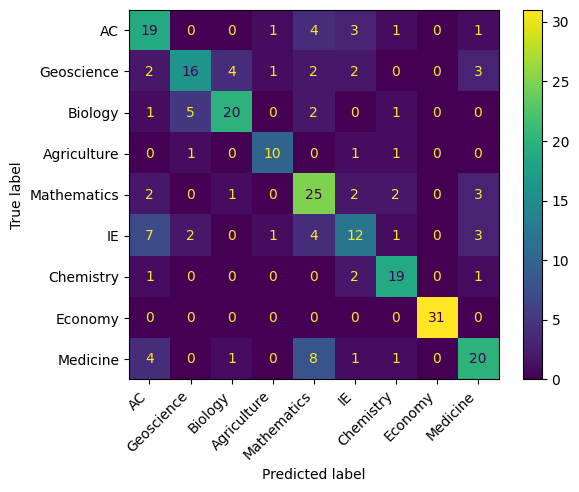

In [37]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000,random_state=random_state_seed, verbose=True)
mlp_classifier.fit(X_train_w2v_normalized, y_train)

# Tokenize and convert the validation set into feature vectors
tokenized_docs_validate = [doc.split() for doc in X_validate]
X_validate_w2v = np.array([np.mean([word2vec_model.wv[word] for word in doc if word in word2vec_model.wv], axis=0) for doc in tokenized_docs_validate])
X_validate_w2v_reduced = pca.transform(X_validate_w2v)
X_validate_w2v_normalized = scaler.transform(X_validate_w2v_reduced)

y_pred = mlp_classifier.predict(X_validate_w2v_normalized)

accuracy = accuracy_score(y_validate, y_pred)
print("Accuracy:", accuracy)

macro_average = f1_score(y_validate, y_pred, average='macro')
print("Macro-average F1 score:", macro_average)

display_labels = ['AC', 'Geoscience', 'Biology', 'Agriculture', 'Mathematics', 'IE', 'Chemistry', 'Economy', 'Medicine']
cm = confusion_matrix(y_validate, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels) 
cm_display.plot()
plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
plt.show()
